(https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/phase-estimation-procedure)

The QFT transforms a computational basis state into a superposition of states in the frequecy basis
it “spreads out” the amplitude of ∣x⟩ across all states, encoding information in the relative phases

The Quantum Fourier Transform (QFT) is the quantum version of the classical Discrete Fourier Transform (DFT). It takes a quantum state expressed in the computational basis and transforms it into a new basis that reveals frequency-like information through quantum phases.

Instead of operating on numbers, the QFT operates on probability amplitudes of a quantum state. It uses quantum phenomena like superposition and interference to perform the transformation extremely efficiently.

For an n-qubit system, the QFT can be implemented using only Hadamard gates, controlled phase rotations, and swap gates, requiring O(n^2) operations. This is exponentially faster than the classical DFT, which requires O(n2^n) operations for equivalent data

Initial Imports

In [7]:
import qiskit
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit_aer.primitives import SamplerV2
import numpy as np
%matplotlib inline


Create the inital state in the computational basis

In [12]:
target = "1010"   
n = len(target)
target = target[::-1]
qcQFT = qiskit.QuantumCircuit(n)
for i in range(n):
    if target[i] == "1":
        qcQFT.x(i)


Define the QFT algorithm

In [10]:
def QFT(circuit, n):
    #loop over each qbit
    for i in range(n):
        # apply a H gate 
        circuit.h(i)
        for k in range(i + 1, n):
            N = np.pi / (2 ** (k - i))
            # perform a controlled phase gate on all other qbits
            circuit.cp(N, k, i)
    for i in range(n // 2): #swap at end
        circuit.swap(i, n - i - 1)


Print the circuit to verify correctness

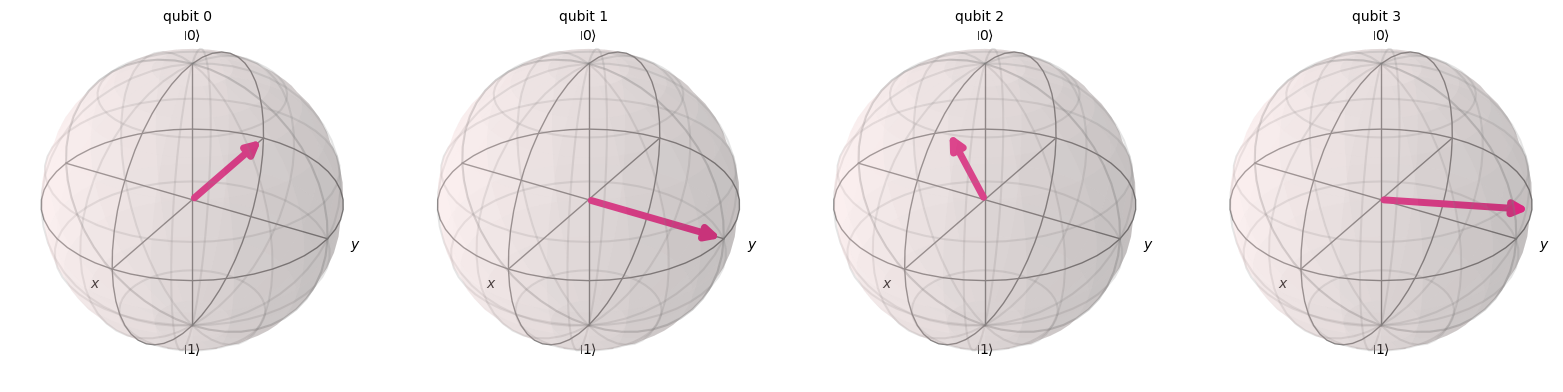

        ┌───┐                                                                »
   q_0: ┤ H ├─■────────■─────────────■───────────────────────────────────────»
        ├───┤ │P(π/2)  │       ┌───┐ │                                       »
   q_1: ┤ X ├─■────────┼───────┤ H ├─┼────────■────────■─────────────────────»
        └───┘          │P(π/4) └───┘ │        │P(π/2)  │       ┌───┐         »
   q_2: ───────────────■─────────────┼────────■────────┼───────┤ H ├─■───────»
        ┌───┐                        │P(π/8)           │P(π/4) └───┘ │P(π/2) »
   q_3: ┤ X ├────────────────────────■─────────────────■─────────────■───────»
        └───┘                                                                »
meas: 4/═════════════════════════════════════════════════════════════════════»
                                                                             »
«                 ░ ┌─┐         
«   q_0: ──────X──░─┤M├─────────
«              │  ░ └╥┘┌─┐      
«   q_1: ──X───┼──░──╫─┤M├──────

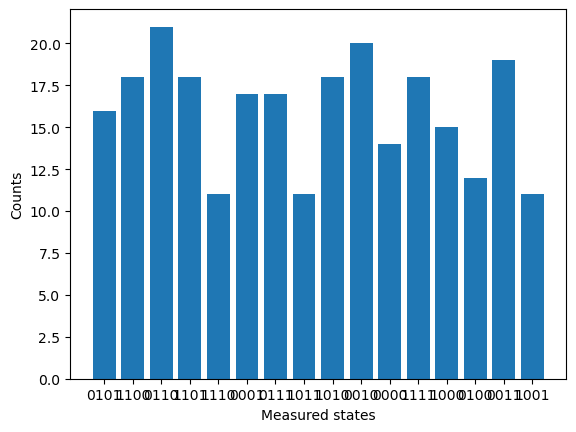

In [13]:
QFT(qcQFT, n)

state = Statevector.from_instruction(qcQFT)

# Plot Bloch spheres
plot_bloch_multivector(state)
plt.show()

qcQFT.measure_all()
sampler = SamplerV2()
result = sampler.run([qcQFT], shots=256).result()
counts = result[0].data.meas.get_counts()

print(qcQFT.draw())
print("Counts QFT:", counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('Measured states')
plt.ylabel('Counts')
plt.show()


Lets also define the inverse QFT
It should be the case that if we apply the QFT then the IQFT we get the orignal state back

In [5]:
def IQFT(circuit, n):
    for i in range(n // 2):
        circuit.swap(i, n - i - 1)
    for i in reversed(range(n)):
        for k in reversed(range(i + 1, n)):
            N = np.pi / (2 ** (k - i))
            circuit.cp(-N, k, i)
        circuit.h(i)


Create the circuit again this time to run QFT then IQFT

     ┌───┐                                        
q_0: ┤ H ├─■────────■───────────────────────────X─
     ├───┤ │P(π/2)  │       ┌───┐               │ 
q_1: ┤ X ├─■────────┼───────┤ H ├─■─────────────┼─
     ├───┤          │P(π/4) └───┘ │P(π/2) ┌───┐ │ 
q_2: ┤ X ├──────────■─────────────■───────┤ H ├─X─
     └───┘                                └───┘   
        ┌───┐                                                               »
   q_0: ┤ H ├─■────────■───────────────────────────X──X─────────────────────»
        ├───┤ │P(π/2)  │       ┌───┐               │  │                ┌───┐»
   q_1: ┤ X ├─■────────┼───────┤ H ├─■─────────────┼──┼───────■────────┤ H ├»
        ├───┤          │P(π/4) └───┘ │P(π/2) ┌───┐ │  │ ┌───┐ │P(-π/2) └───┘»
   q_2: ┤ X ├──────────■─────────────■───────┤ H ├─X──X─┤ H ├─■─────────────»
        └───┘                                └───┘      └───┘               »
meas: 3/════════════════════════════════════════════════════════════════════»
                   

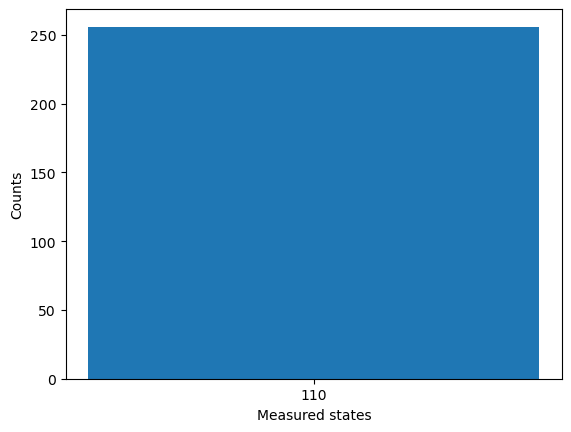

In [6]:
qcIQFT = qiskit.QuantumCircuit(n)

for i in range(n):
    if target[i] == "1":
        qcIQFT.x(i)

QFT(qcIQFT, n)
print(qcIQFT.draw())
IQFT(qcIQFT, n)
qcIQFT.measure_all()
sampler = SamplerV2()
result = sampler.run([qcIQFT], shots=256).result()
counts = result[0].data.meas.get_counts()
print(qcIQFT.draw())
print("Counts IQFT:", counts)
plt.bar(counts.keys(), counts.values())
plt.xlabel('Measured states')
plt.ylabel('Counts')
plt.show()

The circuits look correct and we get the target state back with what appears to be 100% probability